---
# 02_modelgraph_basics.ipynb
---

## Building a ModelGraph

One of the most powerful aspects of ModularML is its `ModelGraph` abstraction, which represents a directed-acyclic-graph (DAG) of computation. This structure allows multiple `ModelStage` instances to be flexibly connected into a larger model pipeline.

Each `ModelStage` can use any supported backend, such as PyTorch, TensorFlow/Keras, or Scikit-learn. This enables the creation of complex multi-objective modeling workflows using a unified interface.

In this example, we demonstrate a two-stage modeling pipeline: a CNN encoder processes input voltage features into a latent embedding, followed by an MLP regressor that estimates the battery state-of-health (SOH) from this embedding.

ModularML provides pre-built classes for commonly used model types such as sequential CNNs and MLPs. While we use those here, any custom model can be integrated by subclassing `modularml.BaseModel` and implementing the required methods.

Let's import the necessary components:

In [1]:
from modularml.core import FeatureSet, ModelStage, ModelGraph, Optimizer
from modularml.models import SequentialCNN, SequentialMLP
import modularml as mml

We will be utilizing the FeatureSet created from the [01_featureset_basics.ipynb](./01_featureset_basics.ipynb) notebook. 

Let's reload that FeatureSet and underlying FeatureTransforms from the `.joblib` file:

In [2]:
from pathlib import Path

FILE_FEATURE_SET = Path("downloaded_data/charge_samples.joblib")
charge_samples = FeatureSet.load(FILE_FEATURE_SET)
charge_samples

FeatureSet(label='ChargePulseFeatures', n_samples=12024)

Now we can start creating our `ModelStages`.

The `modularml.models` module provides convenient, pre-built implementations such as `SequentialCNN` and `SequentialMLP`, which allow for rapid prototyping of convolutional and dense architectures with configurable layer depth and hidden sizes. Please refer to the module documentation for a full list of available initialization parameters.

A key feature of the `ModelStage` abstraction is its support for **lazy shape inference**. Input and output shapes do not need to be explicitly specified during model construction. Instead, ModularML dynamically infers the required shapes at runtime based on how FeatureSets and other ModelStages are connected in the ModelGraph.

While input shape inference is automatic, it is generally advisable to specify the desired output shape for clarity and to avoid unintended behavior.

To construct a `ModelStage`, the following arguments are required:

* `model`: The machine learning model to be wrapped, which must inherit from `BaseModel`.

* `label`: A unique string identifier for the stage.

* `inputs`: A str (or list thereof) indicating the upstream source (either a FeatureSet or another ModelStage).

* `optimizer`: An optional `Optimizer` object used for training, required if the model parameters are to be updated during optimization.

In [3]:
ms_encoder = ModelStage(
    model=SequentialCNN(output_shape=(1, 32), n_layers=2, hidden_dim=16, flatten_output=True),
    label="Encoder",
    inputs='ChargePulseFeatures',  # Input from FeatureSet
    optimizer=Optimizer(name='adam', backend=mml.Backend.TORCH)
)

In [4]:
ms_regressor = ModelStage(
    model=SequentialMLP(output_shape=(1, 1), n_layers=2, hidden_dim=16),
    label='Regressor',
    inputs='Encoder',  # Input from Encoder
    optimizer=Optimizer(name='adam', backend=mml.Backend.TORCH)
)

With both stages defined, we construct the `ModelGraph`. 

`ModelGraph` requires only one argument:

* `nodes`: A list of `ModelStage` or `FeatureSet` instances to incorporate into this ModelGraph. The order of the nodes does not matter, as long as all required inputs are included.

The ModelGraph will handle all data routing, shape inference, and connection validation with the `.build_all()` method.

In [5]:
mg = ModelGraph(nodes=[charge_samples, ms_encoder, ms_regressor])
mg.build_all()

Inferred shapes for `Encoder`:  torch.Size([1, 101]) -> (1, 32)
Inferred shapes for `Regressor`:  (1, 32) -> (1, 1)


We see that the missing input_shapes have been correctly inferred to match `charge_samples.feature_shape` and encoder output shape.


ModelGraph has another useful validation function called `dummy_forward`.
This performs a full forward pass of all connected stages with dummy batch data.

In [6]:
mg.dummy_foward(batch_size=8)

[[[-0.279253751039505]],
 [[-0.279253751039505]],
 [[-0.279253751039505]],
 [[-0.279253751039505]],
 [[-0.279253751039505]],
 [[-0.279253751039505]],
 [[-0.279253751039505]],
 [[-0.279253751039505]]]

Great. We have a fully functional ModelGraph that correctly outputs a target with shape (1,1).

Although this ModelGraph is very simple, as the number of nodes increase, it can be difficult to keep track of how all stages are connected.
We can visuallize these node connections with the `visualize` method.

(<Figure size 600x300 with 1 Axes>, <Axes: >)

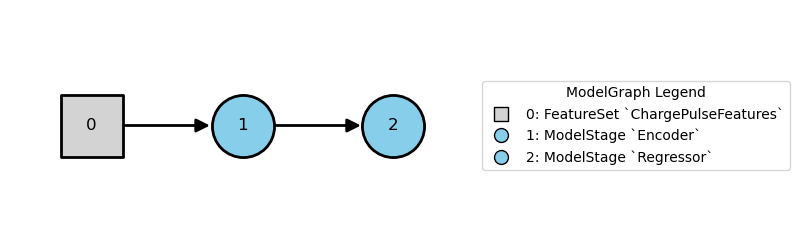

In [7]:
mg.visualize()

This concludes the **02_modelgraph_basics** notebook.

The next tutorial explain the `Experiment` container and ModelGraph training/evaluation logic: [03_training_and_evaluation.ipynb](./03_training_and_evaluation.ipynb)